In [17]:
import torch
import torch.nn as nn
import torchvision.datasets
from torchvision.transforms import ToTensor

In [18]:
train_data = torchvision.datasets.MNIST(root="data",
                                        download=True,
                                        train=True,
                                        transform=ToTensor(),
                                        target_transform=None)
test_data = torchvision.datasets.MNIST(root="data",
                                       download=True,
                                       train=False,
                                       transform=ToTensor(),
                                       target_transform=None)

In [19]:
device = "cpu"

torch.Size([1, 28, 28])

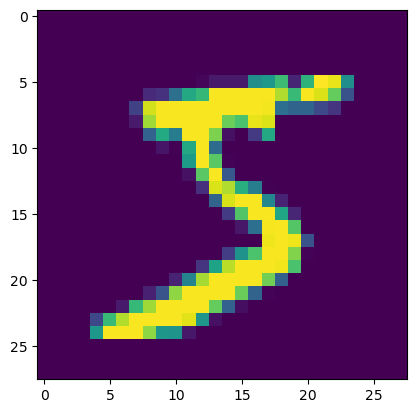

In [20]:
import matplotlib.pyplot as plt

image, label = train_data[0]
plt.imshow(image.squeeze())
image.shape

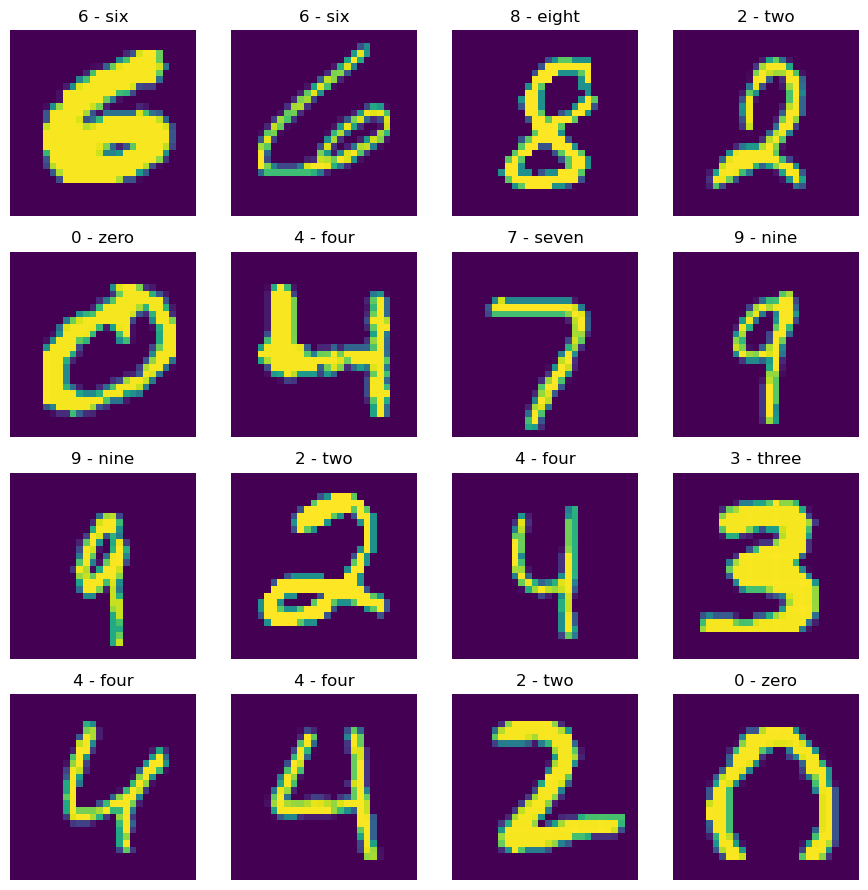

In [67]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, columns = 4, 4

for i in range(1, rows * columns + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.title(train_data.classes[label])
    plt.axis(False)
plt.tight_layout()

In [22]:
from torch.utils.data import DataLoader

In [23]:
train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False)


In [69]:
num_class = train_data.classes

In [24]:
class MNISTClassificationV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int):
        super(MNISTClassificationV1, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=input_shape,
                                              out_channels=hidden_units,
                                              kernel_size=3,
                                              ),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_units,
                                              out_channels=hidden_units,
                                              kernel_size=3
                                              ),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
                                              out_channels=hidden_units,
                                              kernel_size=3
                                              ),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_units,
                                              out_channels=hidden_units,
                                              kernel_size=3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.linear1 = nn.Sequential(nn.Flatten(),
                                     nn.Linear(in_features=hidden_units * 4 * 4,
                                               out_features=num_class)

                                     )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.linear1(x)
        return x

In [25]:
model_2 = MNISTClassificationV1(input_shape=1,
                                hidden_units=10,
                                )

In [26]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

In [55]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [56]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [57]:

from tqdm.auto import tqdm


def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [58]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [59]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.06285 | Train acc: 98.05%
Test loss: 0.05194 | Test acc: 98.37%

Epoch: 1
-------
Train loss: 0.05592 | Train acc: 98.25%
Test loss: 0.04490 | Test acc: 98.50%

Epoch: 2
-------
Train loss: 0.05010 | Train acc: 98.48%
Test loss: 0.04706 | Test acc: 98.41%

Train time on cpu: 74.305 seconds


In [60]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'MNISTClassificationV1',
 'model_loss': 0.047064393758773804,
 'model_acc': 98.41253993610223}

In [71]:
import random

random_digit = random.randint(0, 313)

test_x = test_dataloader.dataset[random_digit][0]
test_y = test_dataloader.dataset[random_digit][1]

In [72]:
test_y

0

In [73]:
test_x.shape

torch.Size([1, 28, 28])

In [76]:
with torch.inference_mode():
    sample = torch.unsqueeze(test_x, dim=0)
    pred_logit = model_2(sample)
    pred_prob = pred_logit.squeeze()
    pred_class = pred_prob.argmax().item()
    print(pred_class)

torch.Size([1, 10])
0
